In [1]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt


### Download data from kaggle

In [2]:
path = kagglehub.dataset_download("jeanmidev/smart-meters-in-london")
TARGET_BLOCKS_DATADIR = os.path.join(path,'hhblock_dataset/hhblock_dataset')
blocks_csv_files = [
        os.path.join(TARGET_BLOCKS_DATADIR, csv_path)
        for csv_path in filter(
            lambda path:
            path.endswith('.csv'),
            os.listdir(TARGET_BLOCKS_DATADIR))
    ]

### Choose the block name and print it

In [3]:
idx = 99
path_specified=f"{TARGET_BLOCKS_DATADIR}/block_{idx}.csv"
block = pd.read_csv(path_specified, encoding='latin', parse_dates=['day'], date_format='%Y-%m-%d')
block.head(5)

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000231,2011-12-02,0.076,0.064,0.005,0.000,0.061,0.009,0.000,0.051,...,0.052,0.103,0.210,0.062,0.065,0.109,0.048,0.520,0.646,0.052
1,MAC000231,2011-12-03,0.000,0.033,0.048,0.000,0.011,0.055,0.007,0.018,...,0.000,0.422,0.510,0.085,0.146,0.484,0.135,0.310,0.105,0.068
2,MAC000231,2011-12-04,0.046,0.023,0.000,0.055,0.209,0.036,0.053,0.001,...,0.088,0.293,0.306,0.111,0.278,0.614,0.723,0.176,0.101,0.155
3,MAC000231,2011-12-05,0.000,0.062,0.002,0.016,0.045,0.000,0.035,0.027,...,0.069,0.719,0.637,0.625,0.652,0.313,0.593,0.766,0.299,0.000
4,MAC000231,2011-12-06,0.039,0.030,0.000,0.036,0.033,0.000,0.028,0.040,...,0.094,0.082,0.106,0.047,0.058,0.567,0.616,0.529,0.112,0.006


### This function is used to fill the gaps between days (missing days)

In [4]:
def convert_consumer_to_standard_form(consumer_data, consumer_id, verbose=False):
  start_date = consumer_data['day'].min()
  end_date = consumer_data['day'].max()
  standrad_df = pd.DataFrame()
  standrad_df['day'] = pd.date_range(start=start_date, end=end_date, freq='1D')
  standard_df  = standrad_df.merge(consumer_data, on=['day'], how='left')
  return standard_df

### This function used to convert data to time series data by frequency 30 min (48 read by day)

In [5]:
def convert_standard_form_to_expand_time_series(standard_df, consumer_id,  verbose=False):
  expand_df = pd.melt(standard_df, id_vars=['day','LCLid'],value_name='energy_consumption',var_name='offset')
  expand_df['offset'] = expand_df['offset'].str.replace('hh_','').astype(int)
  expand_df = expand_df.sort_values(by=['day','offset']).reset_index(drop=True)
  expand_df['frequency'] = '30min'
  expand_df['serie_length'] = len(expand_df)
  expand_df['timestamp'] = pd.date_range(start=standard_df['day'].min(), freq='30min', periods=len(expand_df))
  expand_df = expand_df.drop(columns=['day','offset'])
  expand_df = expand_df[['LCLid','timestamp','energy_consumption','frequency','serie_length']]
  return expand_df

In [6]:
block

,LCLid,day,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,MAC000231,2011-12-02,0.076,0.064,0.005,0.000,0.061,0.009,0.000,0.051,...,0.052,0.103,0.210,0.062,0.065,0.109,0.048,0.520,0.646,0.052
1,MAC000231,2011-12-03,0.000,0.033,0.048,0.000,0.011,0.055,0.007,0.018,...,0.000,0.422,0.510,0.085,0.146,0.484,0.135,0.310,0.105,0.068
2,MAC000231,2011-12-04,0.046,0.023,0.000,0.055,0.209,0.036,0.053,0.001,...,0.088,0.293,0.306,0.111,0.278,0.614,0.723,0.176,0.101,0.155
3,MAC000231,2011-12-05,0.000,0.062,0.002,0.016,0.045,0.000,0.035,0.027,...,0.069,0.719,0.637,0.625,0.652,0.313,0.593,0.766,0.299,0.000
4,MAC000231,2011-12-06,0.039,0.030,0.000,0.036,0.033,0.000,0.028,0.040,...,0.094,0.082,0.106,0.047,0.058,0.567,0.616,0.529,0.112,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33220,MAC005019,2014-02-23,0.212,0.170,0.145,0.228,0.123,0.081,0.130,0.079,...,0.092,0.102,0.081,0.111,0.072,0.135,0.116,0.133,0.092,0.067
33221,MAC005019,2014-02-24,0.064,0.107,0.107,0.122,0.095,0.132,0.085,0.137,...,0.103,0.106,0.103,0.099,0.072,0.097,0.057,0.088,0.046,0.077
33222,MAC005019,2014-02-25,0.053,0.067,0.060,0.076,0.051,0.070,0.033,0.061,...,0.805,1.235,1.243,1.150,0.547,0.418,0.125,0.076,0.041,0.090
33223,MAC005019,2014-02-26,0.045,0.049,0.077,0.032,0.051,0.065,0.042,0.039,...,0.480,0.271,0.214,0.149,0.116,0.165,0.058,0.060,0.077,0.045


In [7]:
result = block.groupby('LCLid').apply(lambda group: convert_consumer_to_standard_form(group, group.name)).reset_index(drop=True)
result

<ipython-input-7-35de716bdf25>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = block.groupby('LCLid').apply(lambda group: convert_consumer_to_standard_form(group, group.name)).reset_index(drop=True)


,day,LCLid,hh_0,hh_1,hh_2,hh_3,hh_4,hh_5,hh_6,hh_7,...,hh_38,hh_39,hh_40,hh_41,hh_42,hh_43,hh_44,hh_45,hh_46,hh_47
0,2011-12-02,MAC000231,0.076,0.064,0.005,0.000,0.061,0.009,0.000,0.051,...,0.052,0.103,0.210,0.062,0.065,0.109,0.048,0.520,0.646,0.052
1,2011-12-03,MAC000231,0.000,0.033,0.048,0.000,0.011,0.055,0.007,0.018,...,0.000,0.422,0.510,0.085,0.146,0.484,0.135,0.310,0.105,0.068
2,2011-12-04,MAC000231,0.046,0.023,0.000,0.055,0.209,0.036,0.053,0.001,...,0.088,0.293,0.306,0.111,0.278,0.614,0.723,0.176,0.101,0.155
3,2011-12-05,MAC000231,0.000,0.062,0.002,0.016,0.045,0.000,0.035,0.027,...,0.069,0.719,0.637,0.625,0.652,0.313,0.593,0.766,0.299,0.000
4,2011-12-06,MAC000231,0.039,0.030,0.000,0.036,0.033,0.000,0.028,0.040,...,0.094,0.082,0.106,0.047,0.058,0.567,0.616,0.529,0.112,0.006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33446,2014-02-23,MAC005019,0.212,0.170,0.145,0.228,0.123,0.081,0.130,0.079,...,0.092,0.102,0.081,0.111,0.072,0.135,0.116,0.133,0.092,0.067
33447,2014-02-24,MAC005019,0.064,0.107,0.107,0.122,0.095,0.132,0.085,0.137,...,0.103,0.106,0.103,0.099,0.072,0.097,0.057,0.088,0.046,0.077
33448,2014-02-25,MAC005019,0.053,0.067,0.060,0.076,0.051,0.070,0.033,0.061,...,0.805,1.235,1.243,1.150,0.547,0.418,0.125,0.076,0.041,0.090
33449,2014-02-26,MAC005019,0.045,0.049,0.077,0.032,0.051,0.065,0.042,0.039,...,0.480,0.271,0.214,0.149,0.116,0.165,0.058,0.060,0.077,0.045


In [8]:
expand_form = result.groupby('LCLid').apply(lambda group: convert_standard_form_to_expand_time_series(group, group.name)).reset_index(drop=True).drop_duplicates()
expand_form

<ipython-input-8-c6c5c428ad93>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  expand_form = result.groupby('LCLid').apply(lambda group: convert_standard_form_to_expand_time_series(group, group.name)).reset_index(drop=True).drop_duplicates()


,LCLid,timestamp,energy_consumption,frequency,serie_length
0,MAC000231,2011-12-02 00:00:00,0.076,30min,38880
1,MAC000231,2011-12-02 00:30:00,0.064,30min,38880
2,MAC000231,2011-12-02 01:00:00,0.005,30min,38880
3,MAC000231,2011-12-02 01:30:00,0.000,30min,38880
4,MAC000231,2011-12-02 02:00:00,0.061,30min,38880
...,...,...,...,...,...
1594795,MAC005019,2014-02-20 21:30:00,0.154,30min,30720
1594796,MAC005019,2014-02-20 22:00:00,0.129,30min,30720
1594797,MAC005019,2014-02-20 22:30:00,0.095,30min,30720
1594798,MAC005019,2014-02-20 23:00:00,0.061,30min,30720


In [9]:
expand_form["energy_consumption"].isna().sum()

np.int64(50)

 - use specific LCLid (consumer) and visualize its reads with time (TimeSeries Analysis)
 - interplolate (impute) the NAN values in the Energy Consumption col

In [10]:
ts_df = expand_form[expand_form.LCLid=="MAC005019"].set_index("timestamp")
ts_df['energy_consumption'] = ts_df['energy_consumption'].interpolate(method='polynomial',order=3)

In [11]:
ts_df

,LCLid,energy_consumption,frequency,serie_length
timestamp,,,,
2012-05-22 00:00:00,MAC005019,0.101,30min,30720
2012-05-22 00:30:00,MAC005019,0.110,30min,30720
2012-05-22 01:00:00,MAC005019,0.078,30min,30720
2012-05-22 01:30:00,MAC005019,0.063,30min,30720
2012-05-22 02:00:00,MAC005019,0.109,30min,30720
...,...,...,...,...
2014-02-20 21:30:00,MAC005019,0.154,30min,30720
2014-02-20 22:00:00,MAC005019,0.129,30min,30720
2014-02-20 22:30:00,MAC005019,0.095,30min,30720


In [12]:
ts_df["energy_consumption"].isna().sum()

np.int64(0)

### Add some properities to use in visualizations and analysis


In [13]:
ts_df["weekday_name"] = ts_df.index.day_name()
ts_df["weekday"] = ts_df.index.weekday
ts_df["week"] = ts_df.index.isocalendar().week
ts_df["day"] = ts_df.index.day
ts_df["hour"] = ts_df.index.hour
ts_df["date"] = ts_df.index.date
ts_df["month"] = ts_df.index.month
ts_df["month_name"] = ts_df.index.month_name()
ts_df["year"] = ts_df.index.year

In [14]:
ts_df['month_name'] = pd.Categorical(ts_df['month_name'], categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)
ts_df['weekday_name'] = pd.Categorical(ts_df['weekday_name'], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)

In [15]:
ts_df

,LCLid,energy_consumption,frequency,serie_length,weekday_name,weekday,week,day,hour,date,month,month_name,year
timestamp,,,,,,,,,,,,,
2012-05-22 00:00:00,MAC005019,0.101,30min,30720,Tuesday,1,21,22,0,2012-05-22,5,May,2012
2012-05-22 00:30:00,MAC005019,0.110,30min,30720,Tuesday,1,21,22,0,2012-05-22,5,May,2012
2012-05-22 01:00:00,MAC005019,0.078,30min,30720,Tuesday,1,21,22,1,2012-05-22,5,May,2012
2012-05-22 01:30:00,MAC005019,0.063,30min,30720,Tuesday,1,21,22,1,2012-05-22,5,May,2012
2012-05-22 02:00:00,MAC005019,0.109,30min,30720,Tuesday,1,21,22,2,2012-05-22,5,May,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-20 21:30:00,MAC005019,0.154,30min,30720,Thursday,3,8,20,21,2014-02-20,2,February,2014
2014-02-20 22:00:00,MAC005019,0.129,30min,30720,Thursday,3,8,20,22,2014-02-20,2,February,2014
2014-02-20 22:30:00,MAC005019,0.095,30min,30720,Thursday,3,8,20,22,2014-02-20,2,February,2014


In [48]:
daily_df = ts_df.groupby(["year","month","week","day"])[['energy_consumption']].mean()
daily_df

energy_consumption
year month week day                    
2012 5     21   22             0.144083
                23             0.217271
                24             0.208083
                25             0.137937
                26             0.158750
...                                 ...
2014 2     7    16             0.179562
           8    17             0.091937
                18             0.251104
                19             0.117604
                20             0.086521

[640 rows x 1 columns]

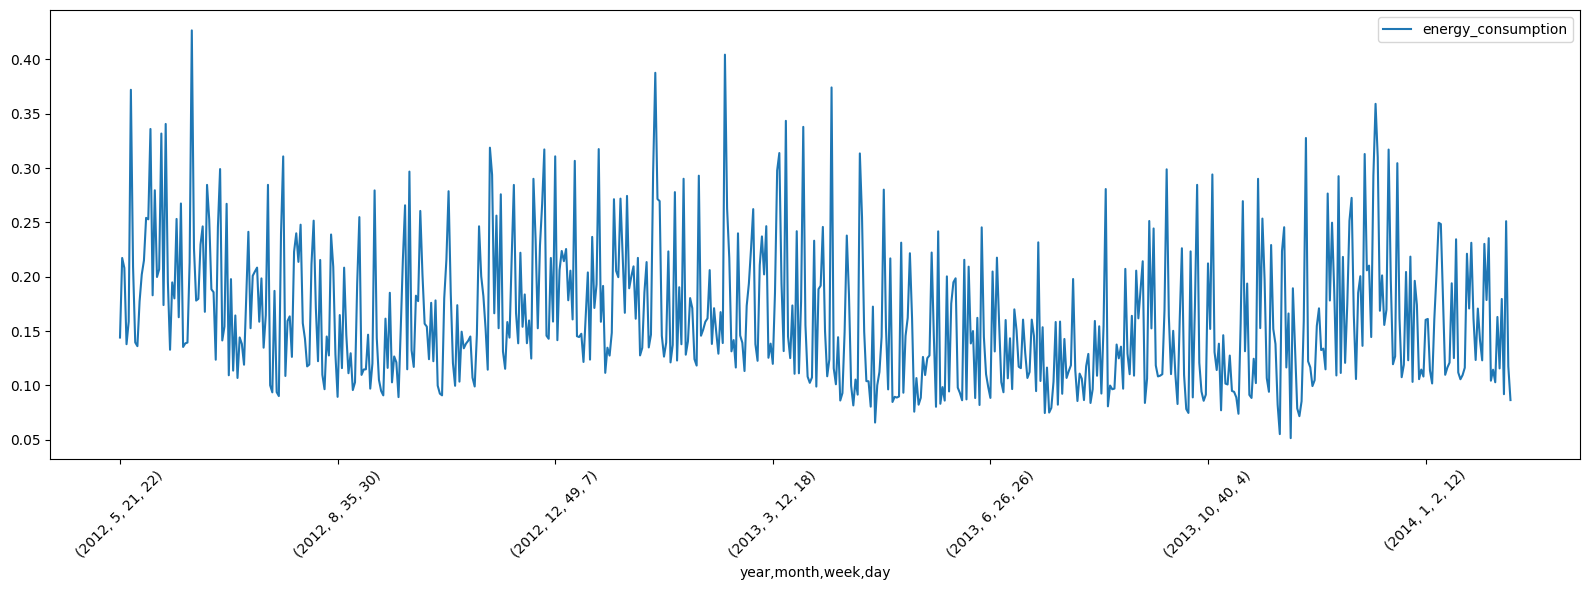

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
daily_df.plot(ax=ax)
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

In [53]:
daily_df= daily_df.reset_index(inplace=False)
daily_df = pd.DataFrame({
    'ds': pd.to_datetime(daily_df[['year', 'month', 'day']]),
    'y': daily_df['energy_consumption']
})

daily_df = daily_df.sort_values('ds')

daily_df.head()

,ds,y
0,2012-05-22,0.144083
1,2012-05-23,0.217271
2,2012-05-24,0.208083
3,2012-05-25,0.137937
4,2012-05-26,0.158750


In [51]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

In [114]:
model1 = Prophet()
model1.fit(daily_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk_fkewil/l2wkiulx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk_fkewil/ugdgw7jy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9203', 'data', 'file=/tmp/tmpk_fkewil/l2wkiulx.json', 'init=/tmp/tmpk_fkewil/ugdgw7jy.json', 'output', 'file=/tmp/tmpk_fkewil/prophet_modeljd9dki3t/prophet_model-20250422193539.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:35:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:35:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [115]:
future = model1.make_future_dataframe(periods=30)
future.tail(30)

,ds
640,2014-02-21
641,2014-02-22
642,2014-02-23
643,2014-02-24
644,2014-02-25
645,2014-02-26
646,2014-02-27
647,2014-02-28
648,2014-03-01
649,2014-03-02


In [116]:
forecast = model1.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-05-22,0.192841,0.113826,0.265172,0.192841,0.192841,-0.002567,-0.002567,-0.002567,-0.002567,-0.002567,-0.002567,0.0,0.0,0.0,0.190273
1,2012-05-23,0.192737,0.098130,0.252119,0.192737,0.192737,-0.018554,-0.018554,-0.018554,-0.018554,-0.018554,-0.018554,0.0,0.0,0.0,0.174183
2,2012-05-24,0.192633,0.100638,0.254775,0.192633,0.192633,-0.014198,-0.014198,-0.014198,-0.014198,-0.014198,-0.014198,0.0,0.0,0.0,0.178435
3,2012-05-25,0.192530,0.106444,0.268633,0.192530,0.192530,-0.003970,-0.003970,-0.003970,-0.003970,-0.003970,-0.003970,0.0,0.0,0.0,0.188560
4,2012-05-26,0.192426,0.115033,0.279497,0.192426,0.192426,0.007282,0.007282,0.007282,0.007282,0.007282,0.007282,0.0,0.0,0.0,0.199708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,2014-03-18,0.158772,0.082222,0.235495,0.158649,0.158875,-0.002567,-0.002567,-0.002567,-0.002567,-0.002567,-0.002567,0.0,0.0,0.0,0.156204
666,2014-03-19,0.158813,0.061746,0.212833,0.158680,0.158920,-0.018554,-0.018554,-0.018554,-0.018554,-0.018554,-0.018554,0.0,0.0,0.0,0.140259
667,2014-03-20,0.158855,0.069964,0.222187,0.158711,0.158970,-0.014198,-0.014198,-0.014198,-0.014198,-0.014198,-0.014198,0.0,0.0,0.0,0.144656
668,2014-03-21,0.158896,0.077244,0.229755,0.158745,0.159019,-0.003970,-0.003970,-0.003970,-0.003970,-0.003970,-0.003970,0.0,0.0,0.0,0.154926


In [117]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
665,2014-03-18,0.156204,0.082222,0.235495
666,2014-03-19,0.140259,0.061746,0.212833
667,2014-03-20,0.144656,0.069964,0.222187
668,2014-03-21,0.154926,0.077244,0.229755
669,2014-03-22,0.166219,0.087581,0.247822


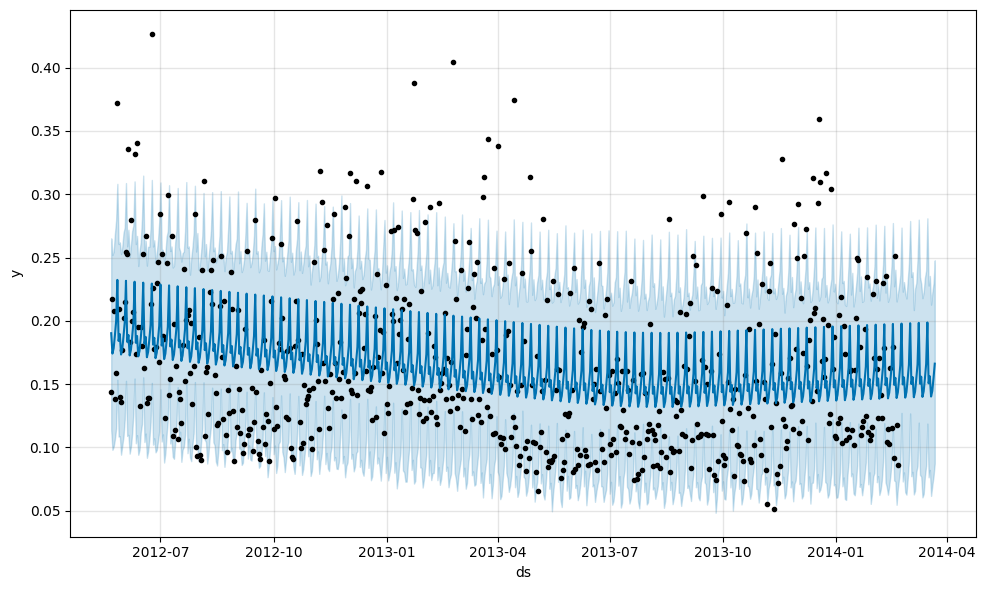

In [118]:
model1.plot(forecast);

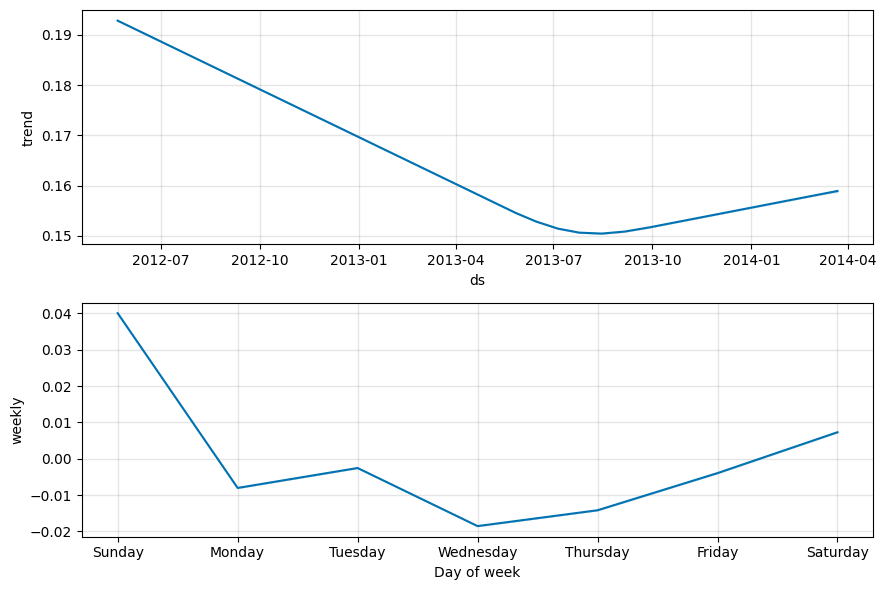

In [119]:
model1.plot_components(forecast);

In [124]:
model2 = Prophet( changepoint_prior_scale=0.05, changepoint_range=0.9, seasonality_mode='multiplicative', seasonality_prior_scale=10, yearly_seasonality=8,weekly_seasonality=False,
    daily_seasonality=False, holidays_prior_scale=0.1, mcmc_samples=300 )

model2.fit(daily_df)

future = model2.make_future_dataframe(periods = 30)

forecast = model2.predict(future)

DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk_fkewil/3ehc4krm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk_fkewil/tbcg0yo0.json
19:37:57 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=61485', 'data', 'file=/tmp/tmpk_fkewil/3ehc4krm.json', 'init=/tmp/tmpk_fkewil/tbcg0yo0.json', 'output', 'file=/tmp/tmpk_fkewil/prophet_model3zoygafa/prophet_model-20250422193757_1.csv', 'method=sample', 'num_samples=150', 'num_warmup=150', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=61485', 'data', 'file=/tmp/tmpk_fkewil/3ehc4krm.json', 'init=/tmp/tmpk_fkewil/tbcg0yo0.json', 'output', 'file=/tmp/tmpk_fkewil/prophet_model3zoygafa/prophet_model-20250422193757_2.csv', 'method=sample', 'num_samples=150', 'num_warmup=150', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmds

19:38:13 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=61485', 'data', 'file=/tmp/tmpk_fkewil/3ehc4krm.json', 'init=/tmp/tmpk_fkewil/tbcg0yo0.json', 'output', 'file=/tmp/tmpk_fkewil/prophet_model3zoygafa/prophet_model-20250422193757_1.csv', 'method=sample', 'num_samples=150', 'num_warmup=150', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpk_fkewil/prophet_model3zoygafa/prophet_model-20250422193757_1.csv
 console_msgs (if any):
	/tmp/tmpk_fkewil/prophet_model3zoygafa/prophet_model-20250422193757_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 150
    num_warmup = 150
    save_warmup = 0 (Default)
    thin = 1 (Defau

In [125]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
665,2014-03-18,0.178858,0.094305,0.259252
666,2014-03-19,0.178803,0.095708,0.257052
667,2014-03-20,0.178564,0.097626,0.258576
668,2014-03-21,0.178145,0.100338,0.257767
669,2014-03-22,0.177547,0.098815,0.260731


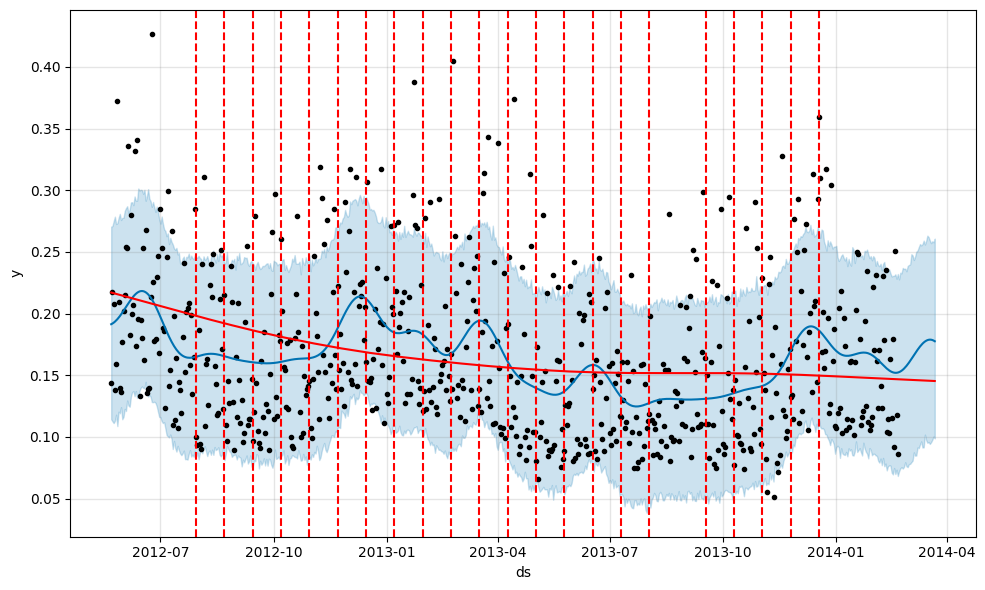

In [128]:
fig = model2.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model2, forecast)

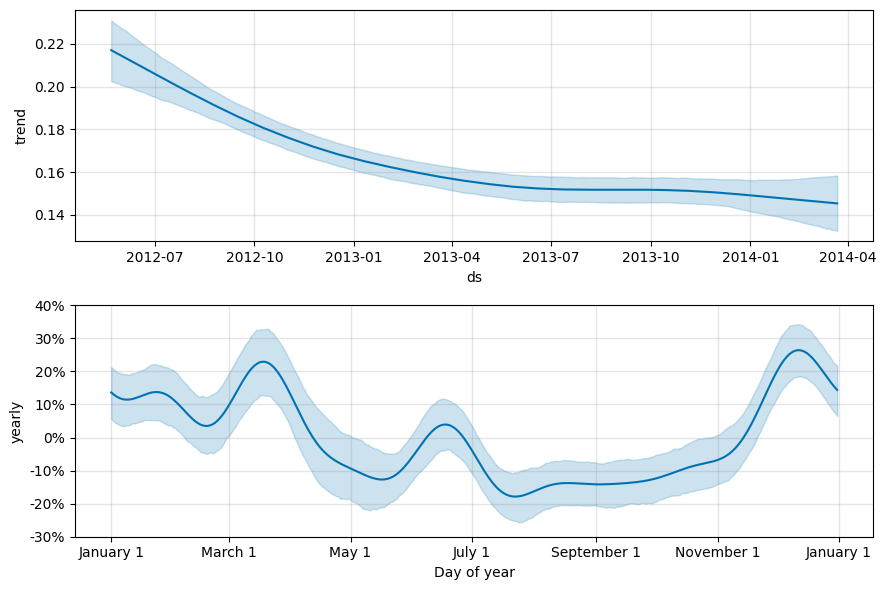

In [129]:
fig = model2.plot_components(forecast)

In [172]:
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

In [217]:
initial = 600
initial = str(initial) + ' days'

period = 1 * 365
period = str(period) + ' days'

horizon = 30
horizon = str(horizon) + ' days'

print("initial: ", initial)
print("period: ", period)
print("horizon: ", horizon)

initial:  600 days
period:  365 days
horizon:  30 days


In [218]:
df_cv = cross_validation(model2, initial=initial, period=period, horizon=horizon)

INFO:prophet:Making 1 forecasts with cutoffs between 2014-01-21 00:00:00 and 2014-01-21 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:cmd: /usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk_fkewil/n3piajbf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk_fkewil/65gujk6e.json
19:57:41 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=99606', 'data', 'file=/tmp/tmpk_fkewil/n3piajbf.json', 'init=/tmp/tmpk_fkewil/65gujk6e.json', 'output', 'file=/tmp/tmpk_fkewil/prophet_modelrtvyrblr/prophet_model-20250422195741_1.csv', 'method=sample', 'num_samples=150', 'num_warmup=150', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'id=2', 'random', 'seed=99606', 'data', 'file=/tmp/tmpk_fkewil/n3piajbf.json', 'init=/tmp/tmpk_fkewil/65gujk6e.json', 'output', 'file=/tmp/tmpk_fkewil/prophet_modelrtvyrblr/prophet_model-20250422195741_2.csv', 'method=sample', 'num_samples=150', 'num_warmup=150', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmds

19:57:53 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'id=1', 'random', 'seed=99606', 'data', 'file=/tmp/tmpk_fkewil/n3piajbf.json', 'init=/tmp/tmpk_fkewil/65gujk6e.json', 'output', 'file=/tmp/tmpk_fkewil/prophet_modelrtvyrblr/prophet_model-20250422195741_1.csv', 'method=sample', 'num_samples=150', 'num_warmup=150', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpk_fkewil/prophet_modelrtvyrblr/prophet_model-20250422195741_1.csv
 console_msgs (if any):
	/tmp/tmpk_fkewil/prophet_modelrtvyrblr/prophet_model-20250422195741_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 150
    num_warmup = 150
    save_warmup = 0 (Default)
    thin = 1 (Defau

In [219]:
df_cv.groupby('cutoff').count()

,ds,yhat,yhat_lower,yhat_upper,y
cutoff,,,,,
2014-01-21,30,30,30,30,30


In [220]:
metrics = performance_metrics(df_cv)
metrics

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,0.002590,0.050890,0.045397,0.368651,0.492745,0.297868,1.000000
1,4 days,0.002293,0.047883,0.042917,0.336139,0.448888,0.277013,1.000000
2,5 days,0.002041,0.045175,0.040677,0.247088,0.225593,0.229990,1.000000
3,6 days,0.003606,0.060051,0.059607,0.432551,0.448888,0.365336,1.000000
4,7 days,0.004476,0.066905,0.066193,0.522440,0.623172,0.419344,1.000000
5,8 days,0.005269,0.072585,0.072540,0.666133,0.656672,0.499372,1.000000
6,9 days,0.005051,0.071073,0.070926,0.644446,0.656672,0.486444,1.000000
7,10 days,0.003672,0.060599,0.059069,0.465774,0.558110,0.377192,1.000000
8,11 days,0.001977,0.044469,0.038254,0.265401,0.182540,0.230424,1.000000
9,12 days,0.001461,0.038217,0.033817,0.153732,0.182540,0.168680,1.000000


/usr/local/lib/python3.11/dist-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


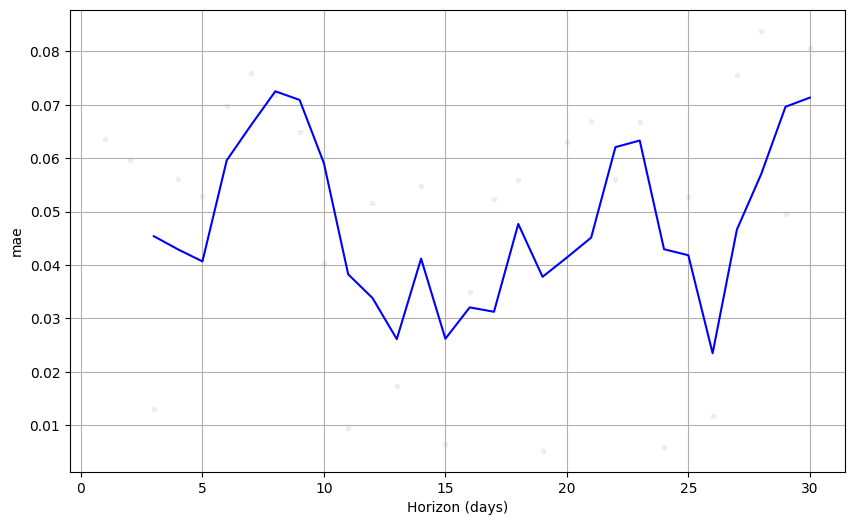

In [221]:
plot_cross_validation_metric(df_cv, metric='mae');

/usr/local/lib/python3.11/dist-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


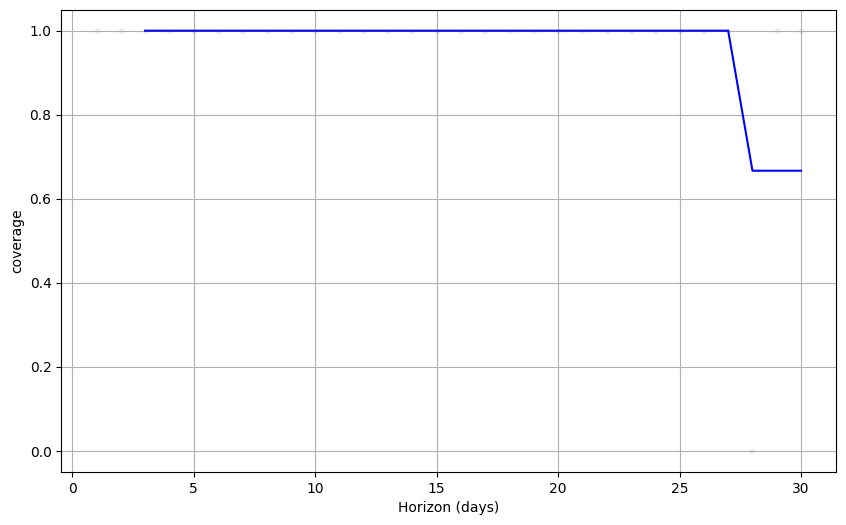

In [222]:
plot_cross_validation_metric(df_cv, metric='coverage');